# Assignment 3 - FWI

GISC405
Rayne Davidson

In [1]:
import datetime
import numpy as np
import xarray as xr # see details from: https://docs.python.org/3/library/warnings.html
import warnings
import fwi_nz as fwi_calc  # The fwi calculator, make sure to have fwi_nz.py in the same folder as this notebook
warnings.filterwarnings('ignore')
import envlib_helper as envlib
from tethysts import Tethys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns #used for better violin plots than mpl had (more versatile it seemed)
import cartopy as cart #used for ocean masking
# import cmasher as cmr #I had to pip install cmasher as well to use this - this is for cmap restriction
import xarray as xr
import numpy as np #used for math
import salem #used for map features
import cartopy.crs as ccrs #module for orthographic projections
import glob 

setting up variables

In [2]:
ts = Tethys()
envlib.get_all_dataset_information(ts)

owner = "FENZ"
method = "sensor_recording"
product_code = "raw_data"

# true nearest station to EVR doesnt record precip
# this is nearest that does record precip (Murupara)
EVR_lat= -43.7143
EVR_lon =172.5922

# --------
# Dates to use throughout notebook
fire_date="2017-02-13"
week_start="2017-02-06"
month_start="2017-01-13"
twomonth_start="2016-12-15"

summerstart="2016-09-01"
summerend="2017-04-01"

startdates=[[week_start, "One Week Prior"],
            [month_start, "One Month Prior"],
            [twomonth_start,"Two Months Prior"]]

# months and years for Q2
months_end="2017-05-01"
yearstart="2000"
yearend="2020"

Months=pd.period_range(summerstart, months_end, 
                             freq='M').strftime("%m").tolist()
del Months[-1] 

word_months = pd.date_range(summerstart,months_end, 
                            freq='M').strftime("%b").tolist()

Years = pd.period_range(yearstart, yearend, 
                            freq='Y').strftime("%Y").tolist()

# ----------
# having all the lat and lons like this is probably unnessecary 
# but would make swapping out for other cities fairly easy
citynames=["Napier", "Christchurch", "Greymouth"]

chch_lat_max=-43.57
chch_lon_max=172.72
chch_lat_min=-43.47
chch_lon_min=172.50
chch_lat_combo=[chch_lat_min, chch_lat_max]
chch_lon_combo=[chch_lon_min, chch_lon_max]
chch_bounds=[chch_lat_combo, chch_lon_combo, citynames[1]]

napier_lat_max=-39.55
napier_lon_max=176.91
napier_lat_min=-39.46
napier_lon_min=176.82
napier_lat_combo=[napier_lat_min, napier_lat_max]
napier_lon_combo=[napier_lon_min, napier_lon_max]
napier_bounds=[napier_lat_combo, napier_lon_combo, citynames[0]]

greymouth_lat_max=-42.72
greymouth_lon_min=171.24
greymouth_lat_min=-42.54
greymouth_lon_max=171.15
greymouth_lat_combo=[greymouth_lat_min, greymouth_lat_max]
greymouth_lon_combo=[greymouth_lon_min, greymouth_lon_max]
greymouth_bounds=[greymouth_lat_combo, greymouth_lon_combo, citynames[2]]

Cities = [napier_bounds,chch_bounds, greymouth_bounds]

## Q1

In [3]:
EVR_station_data = envlib.get_data_from_lat_lon(
    ts, owner, method, product_code, EVR_lat, EVR_lon,squeeze_dims=False).sel(height=2) #squeeze removes extra?

Ensuring no rain occured on start day of evaluation

In [4]:
def plotPrecip(data, axis, timeprior):
    
    data.plot(ax=ax[axis])
    ax[axis].set_title(f'{timeprior} prior', fontsize=10)
    ax[axis].set_xlabel("Date before Fire", fontsize=8)
    ax[axis].set_ylabel("Rainfall mm", fontsize=8)
    ax[axis].tick_params(axis="x", labelsize=7, rotation=15)

In [5]:
# confirm there is no precipitation on start dates desired
oneweek_precip=EVR_station_data.sel(time=slice(week_start,fire_date)).precipitation
onemonth_precip=EVR_station_data.sel(time=slice(month_start,fire_date)).precipitation
twomonth_precip=EVR_station_data.sel(time=slice(twomonth_start,fire_date)).precipitation

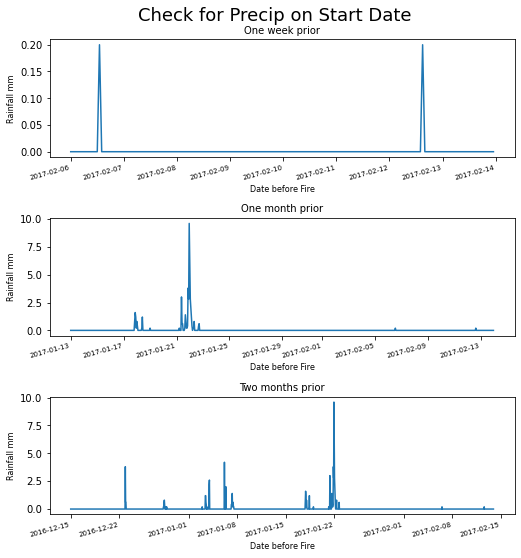

In [6]:
fig, ax = plt.subplots(3, figsize=(8, 8), layout='constrained')
fig.tight_layout(pad=4)
fig.suptitle("Check for Precip on Start Date", fontsize=18)

plotPrecip(oneweek_precip, 0, "One week")

plotPrecip(onemonth_precip, 1, "One month")

plotPrecip(twomonth_precip, 2, "Two months")

### Q1a & Q1b - FWI near EVR by FENZ compared to by WRF data

In [7]:
# I made this to sort of making the data retreival, time and location slice, and WS calc easier
# but honestly the amount of kwds is irritating and doesn't feel very efficent

def WRF_data_by_interest (interest, lat, lon, start, end,  interest2=""):
    
#     ---------
#     if no 2nd interest (for WS) is listed, go throught this procedure
    if interest2=="":
        
#         retrieve the data
        interest1_data=(xr.open_mfdataset(
            '/mnt/data/MetService_WRF/'+interest+'_201[6-7]*',
            chunks={"time":24,"height":1},
            parallel=True))
        
#         ---------
#         time and location slice the data
        if interest=="RAINNC":
        
#             rain has no height and cant use the same procedure so it needs it's own (annoying)
            interest1_located=(interest1_data.RAINNC
                               .sel(lat=lat,lon=lon, method='nearest'))
        
            interest1_dated= (interest1_located.sel(time=slice(start,end)))
            
            return interest1_dated
#         --------
#         time and location slice data that has height component
        else: 
#             i couldnt figure out a way to make the .interst (i.e. .RH, etc) be able  to be a var
#             so it has to be specified when calling the function
            interest1_located=(
                interest1_data
                         .sel(height=0, lat=lat,lon=lon, method='nearest'))

            interest1_dated= (
                interest1_located.sel(
                    time=slice(start,end)))
        
        return interest1_dated
    
#     ---------
    elif interest2:
        
#         time and location slice WS, both U & V can be called into function ....but 
#         interest 1 must be U and interest 2 must be V 
        interest1_data=(xr.open_mfdataset(
            '/mnt/data/MetService_WRF/'+interest+'_201[6-7]*',
            chunks={"time":24,"height":1},
            parallel=True))

        interest1_located=(
            interest1_data.U
                     .sel(height=0, lat=lat,lon=lon, method='nearest'))

        interest1_dated= (
            interest1_located.sel(
                time=slice(start,end)))        
        
        
        interest2_data=(xr.open_mfdataset(
            '/mnt/data/MetService_WRF/'+interest2+'_201[6-7]*',
            chunks={"time":24,"height":1},
            parallel=True))
        
        interest2_located=(interest2_data.V
                           .sel(height=0, lat=lat,lon=lon, method='nearest'))
    
        interest2_dated= (interest2_located
                          .sel(time=slice(start,end)))
        
#         calc windspeed, dont need to convert        
        Windspeed=np.sqrt((interest1_dated**2)+(interest2_dated**2))
        
        return Windspeed

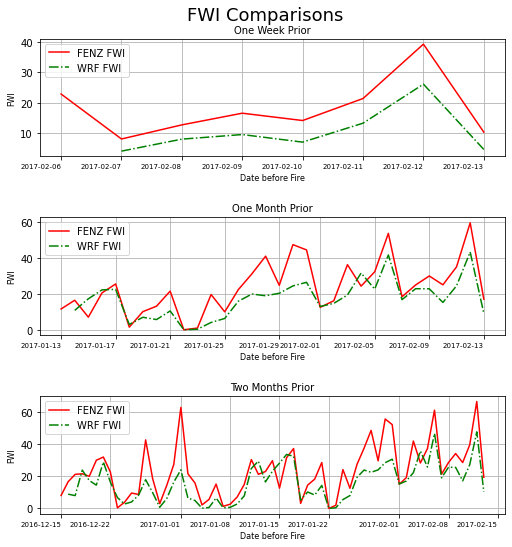

In [8]:
# i have no idea why my WRF data is a day short & cant figure it out
# my fig size was smaller than i meant it to be but my environment is broken 
# so i cant re-run this to fix it, so sorry the figures are too small, the figsize 
# 15,25 that's listed is what I would change it to if I could re-run it 

fig, axes=plt.subplots(3, figsize=(15, 25), layout='constrained')
fig.tight_layout(pad=4)
fig.suptitle("FWI Comparisons", fontsize=18)

for day, ax in zip(startdates, axes):
#     just the fwi calculatior
    ffmc_data, dmc_data, dc_data, isi_data, bui_data, FENZ_fwi_data = fwi_calc.FWI_combined_calc(
    EVR_station_data.temperature,
    EVR_station_data.relative_humidity,
    EVR_station_data.wind_speed,
    EVR_station_data.precipitation,
    start_date=day[0], 
    end_date = fire_date,
    ws_unit="m/s")
    
#     -------
#     just the fwi calculator using function
    ffmc_data, dmc_data, dc_data, isi_data, bui_data, WRF_fwi_data = fwi_calc.FWI_combined_calc(
    (WRF_data_by_interest("T", EVR_lat, EVR_lon, day[0], fire_date)).T-273,
    WRF_data_by_interest("RH", EVR_lat, EVR_lon, day[0], fire_date).RH,
    WRF_data_by_interest("U", EVR_lat, EVR_lon, day[0], fire_date, interest2="V"),
    WRF_data_by_interest("RAINNC", EVR_lat, EVR_lon, day[0], fire_date),
    start_date=day[0],  
    end_date = fire_date,
    ws_unit="m/s")
    
#     --------
#     plot the 2 on same plot to compare easier
    FENZ_fwi_data.plot(ax=ax, color="red", label="FENZ FWI", linestyle="-")
    WRF_fwi_data.plot(ax=ax, color="green", label="WRF FWI", linestyle="-.")
    ax.set_title(day[1], fontsize=10)
    ax.set_xlabel("Date before Fire", fontsize=8)
    
    ax.legend()
    ax.set_ylabel("FWI", fontsize=8)
    ax.tick_params(axis="x", labelsize=7, rotation=0)
    ax.grid()

### Q1c

The FWI predicted by the WRF data is fairly consistently lower than what was actually recorded by the FENZ weather station. The biggest difference between the two occured around the last week of January 2017. However, generally the WRF data was always in roughly the same shape (highs when FENZ was high, low when FENZ was low) as the FENZ data, just predicting lower generally. The low predictions were pretty drastic in some areas, such as January 1st 2017, when the FENZ station recoreded a FWI of ~60 while the WRF data only predicted a FWI of ~20. 

## Q2

### Q2a - regions which experince FWI > 31 in September-April

In [9]:
# open kit's fwi df for years needed
Kit_FWI_16_17=(xr.open_mfdataset(
    '/mnt/data/FWI_WRF/FWI_201[6-7]*',
    chunks={"time":24},
    parallel=True))

# time slice, select by condition and count
Kit_FWI_summer=(Kit_FWI_16_17.sel(time=slice(summerstart,summerend)))
Kit_FWI_extreme=Kit_FWI_summer.FWI.where(Kit_FWI_summer.FWI >= 31,None)
Kit_FWI_extreme_counted=Kit_FWI_extreme.count(dim="time")

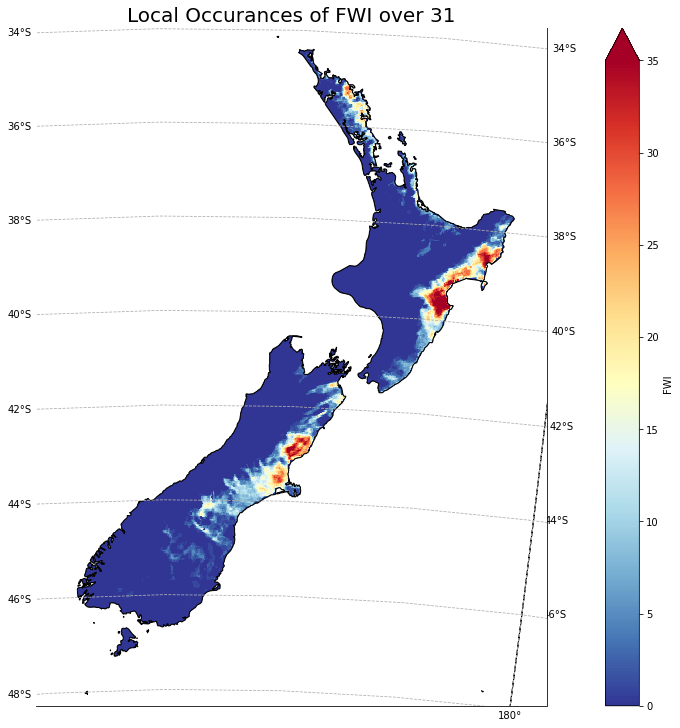

In [10]:
# plot.....mostly copied from my HW2
plt.figure(1, constrained_layout=True, figsize=(10,10))
map_proj = ccrs.Orthographic(170, -45) # cartopy projection set
ax = plt.axes(projection=map_proj) 

ax.coastlines() 
ax.add_feature(cart.feature.OCEAN, zorder=5, edgecolor='black', facecolor='white')

# i made the vmax a little lower than the default to increase contrast
Kit_FWI_extreme_counted.plot(ax=ax,transform=Kit_FWI_extreme_counted.salem.cartopy(), vmax=35, cmap="RdYlBu_r")
ax.set_title("Local Occurances of FWI over 31", fontsize=20)
ax.gridlines(zorder=6, linestyle="--", draw_labels=True)
cax = fig.get_axes()[2]
cax.set_ylabel("Days over FWI 31");

The regions that have the most frequent occurances of extreme fire weather conditions are around Pegasus Bay and Christchurch on the east coast of the south island, Hawke and Poverty Bay on the east coast of the north island, and on the east/northeast edge of the northwestern tip of the north island. 

### Q2b - FWI trends in Christchurch, Napier & Greymouth across 20 years

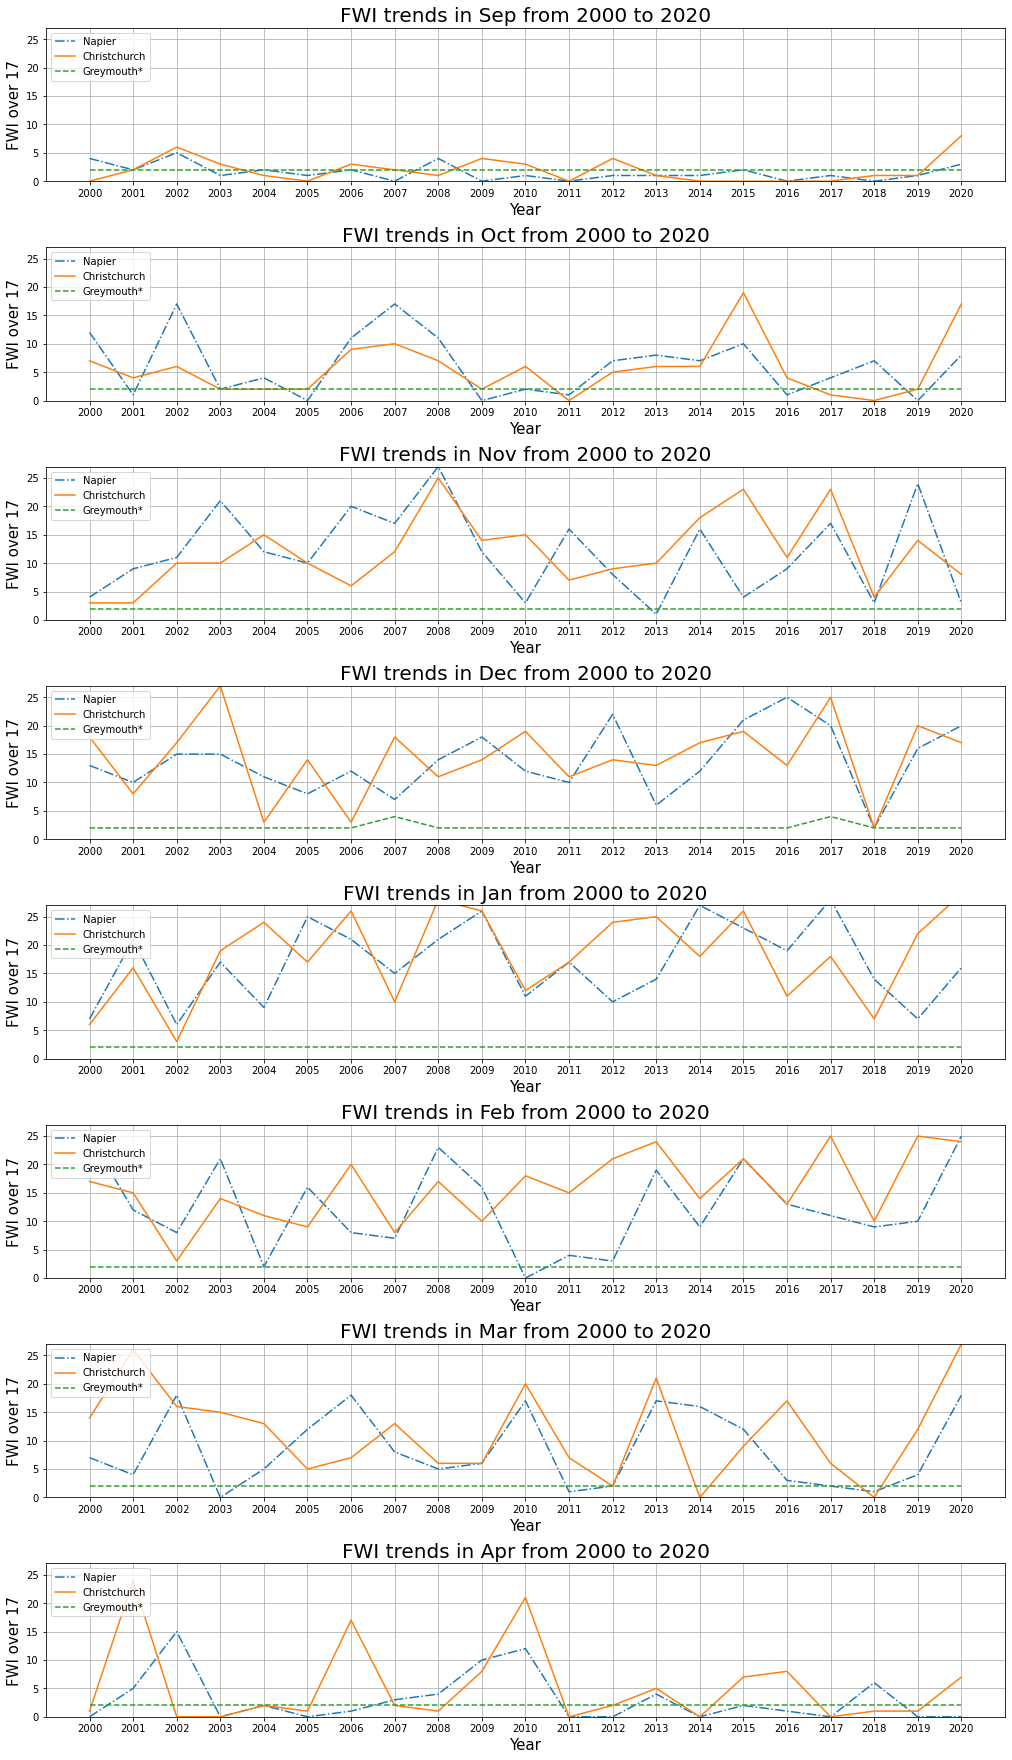

In [11]:
fig, axes=plt.subplots(8, figsize=(15, 25), layout='constrained')
fig.tight_layout(pad=4.5)
month_end_date="-31"
monthendsin30=["09", "11", "04"]

for plotmonth, ax in enumerate(axes):
#     creating an empty df for each city (i know it could be done better but oh well)
    napierdf=pd.DataFrame()
    chchdf=pd.DataFrame()
    grymth=pd.DataFrame()

    for city in Cities:
        """creating empty df for each month collecting all data fram years per month for each city"""
        one_month_across_all_years=pd.DataFrame()

        for month in Months:
#             emtpy list to add to df 
            onemonth=[]
    
            for year in Years:
            
                """get data, select by location bounds of relavent cities"""
                FWI_year=(xr.open_mfdataset(
                        '/mnt/data/FWI_WRF/FWI_'+year+"*",
                        chunks={"time":24},parallel=True))
                
                located_year=(FWI_year.sel(lat=slice(min(city[0]), max(city[0])),
                                           lon=slice(min(city[1]), max(city[1]))))
                
#                 --------
                """slice year of data to just month of interest"""
#                 kind of hackey way to handle months ending in different numbers
                if month == "02":
                    month_end_date="-28"
                    
                    FWI_month_year_located=(located_year.sel(time=slice((year+"-"+month+"-01"),
                                                                (year+"-"+month+month_end_date))))
                elif month in monthendsin30:
                    month_end_date="-30"
                    FWI_month_year_located=(located_year.sel(time=slice((year+"-"+month+"-01"),
                                                                (year+"-"+month+month_end_date))))
                else: 
                    FWI_month_year_located=(located_year.sel(time=slice((year+"-"+month+"-01"),
                                                                (year+"-"+month+month_end_date))))
                
#                 --------
                """narrow to just >17, replace <17 with 0, get rid of extra dimentions, count, add to list
                (honetly i am not 100% this was how to do it but i couldnt figure out any other way)"""
                FWI_over17_located=(FWI_month_year_located.FWI.where(
                    (FWI_month_year_located.FWI >= 17), 0).sum(dim=["lat","lon"]))
                
                Month_year_counted_located2=FWI_over17_located.to_pandas().tolist()

                totalcounts=np.count_nonzero(Month_year_counted_located2)

                onemonth.append(totalcounts)

            placeholder=pd.DataFrame([onemonth], columns=Years) 

            one_month_across_all_years=pd.concat(
                [one_month_across_all_years, placeholder])
            
#         -------
        """add temporary dfs to relavent permanant city df"""
#         this also feels kind of hackey but -\/- 
#         i could probably do this better with a list of dfs and enumerate the for loop maybe
        if city[2]==citynames[0]:
            napierdf=pd.concat(
                [napierdf, one_month_across_all_years])

        if city[2]==citynames[1]:
            chchdf=pd.concat(
                [chchdf, one_month_across_all_years])

        if city[2]==citynames[2]:
            grymth=pd.concat(
                [grymth, one_month_across_all_years])
            
#     -------
    """add month names and set index"""
    napierdf["Month"]=word_months 
    napierdf=napierdf.set_index("Month") 

    chchdf["Month"]=word_months 
    chchdf=chchdf.set_index("Month") 

    grymth["Month"]=word_months 
    grymth=grymth.set_index("Month") 
    
#     ------
#     since we arent comparing the cities to each other, i am scaling
#     greymouth up so it is more readable
    grymth += 1
    grymthscaled=grymth*2
    
#     --------
    """Plot"""
    ax=ax
    ax.plot(napierdf.iloc[plotmonth], label="Napier", linestyle="-.")
    ax.plot(chchdf.iloc[plotmonth], label="Christchurch", linestyle="-")
    ax.plot(grymthscaled.iloc[plotmonth], label="Greymouth*", linestyle="--")
    
    ax.set_title(f'FWI trends in {word_months[plotmonth]} from 2000 to 2020', fontsize=20)
    ax.set_xlabel("Year", fontsize=15)
    
    ax.set_ylim(bottom=0, top=27)
    ax.legend(loc="upper left")
    ax.set_ylabel("FWI over 17", fontsize=15)
    ax.tick_params(axis="x", labelsize=10, rotation=0)
    ax.grid();

**Greymouth values are increased by 1 and then multiplied by a factor of two to make the plot more readable*

***All plots share the same y-axis values to properly compare across the plots*

### Q2b - is fire weather beginning earlier?

There does not appear to be a significant trend of fire weather >17 instances increasing in September in any of the three cities. In Christchurch and Napier there appears to be a trend of decreasing fire weather isntances in April from approzimatlely 2011 onwards. (I know we were only meant to plot until april 1 but I made a mistake and am committed at this point). Christchurch has some trends in October of increased instances of fire weather since 2000, though Napier does not. November and February both have increasing days with time with a fire weather >17 in Christchurch, while Napier's strongest increasting trends are in December and January. Greymouth is on the west cost which experiences rain quite frequently even in the summer months. FWI over 17 appears to be very infrequent in Greymouth with no obvious trends. 